In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [ ]:
from dataloader import *
import torchvision
from torchvision import transforms, datasets, models
import os
from torch.utils.data import DataLoader, random_split
te_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Image')
te_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Mask')

batch_size = 1

dataset = DatasetGenerate(te_img_folder, te_gt_folder)

loader_args = dict(batch_size=batch_size, num_workers=4, prefetch_factor =2 , pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, **loader_args)

dataloaders = {
    'test': test_loader
}

batch = next(iter(dataloaders['test']))
image = batch['image'].squeeze(dim=0).permute(1, 2, 0).numpy()
mask = batch['mask'][:, -1, :, :].squeeze(dim=0).numpy()

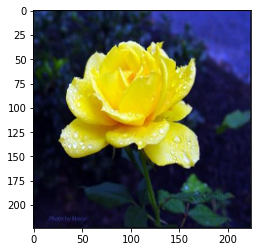

In [50]:
y_mask = cv2.imread(r'E:\paper_data\MSRA10K_Imgs_GT\MSRA10K_Imgs_GT\Imgs\32258.png')
y_mask = cv2.resize(y_mask, (224, 224))
# y_mask = cv2.cvtColor(y_mask.astype('float32'), cv2.COLOR_BGR2GRAY)
y = cv2.imread(r'E:\paper_data\MSRA10K_Imgs_GT\MSRA10K_Imgs_GT\Imgs\32258.jpg')
y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
y = cv2.resize(y, (224, 224))
y = y
plt.imshow(y)

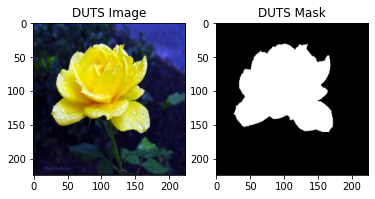

ValueError: operands could not be broadcast together with shapes (224,224,3) (224,224,3,3) 

In [3]:
# p = sample(image_list, 1)[0]

# y_mask = cv2.imread(r'data/DUTS/DUTS-TR/DUTS-TR-Mask/' + os.path.basename(p).split('.')[0] + '.png') / 255.0
# y_mask = cv2.cvtColor(y_mask.astype('float32'), cv2.COLOR_BGR2GRAY)
# y = cv2.imread(p, 1)[:, :, ::-1] / 255.0

# y_mask = mask
# y = image

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(y)
ax1.set_title('DUTS Image')
ax2.imshow(y_mask, 'gray')
ax2.set_title('DUTS Mask')
plt.show()

smooth_y = np.multiply(cv2.blur(y, (9, 9)), 1-np.repeat(y_mask[:,:,np.newaxis], 3, axis=2))
ground_y = np.multiply(y, np.repeat(y_mask[:,:,np.newaxis], 3, axis=2))
new_y = smooth_y + ground_y

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 25))
ax1.imshow(smooth_y)
ax1.set_title('smooth background')
ax2.imshow(ground_y)
ax2.set_title('real foreground')
ax3.imshow(new_y)
plt.show()

In [ ]:
y_re = cv2.resize(y, (224, 224))
y_fshit = np.fft.fftshift(np.fft.fft2(cv2.cvtColor(y_re.astype('float32'), cv2.COLOR_BGR2GRAY)))

y_fore = cv2.resize(ground_y, (224, 224))
y_forefshift = np.fft.fftshift(np.fft.fft2(cv2.cvtColor(y_fore.astype('float32'), cv2.COLOR_BGR2GRAY)))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax0.imshow(y_re), ax0.set_title('orig y')
ax1.imshow(y_fore), ax1.set_title('y real foreground')
ax2.imshow(np.log(np.abs(y_fshit)), 'gray'), ax2.set_title('orig y (224*224) amplitude')
ax3.imshow(np.log(np.abs(y_forefshift)), 'gray'), ax3.set_title('y real foreground amplitude')
# fig.savefig('amplitude/' + os.path.basename(p))
# plt.close(fig)
plt.show()

# Spectral residual

In [ ]:
def Spectral_residual(inputdata):
	fourier = np.fft.fft2(inputdata) #做傅立葉轉換
	fourier_shift= np.fft.fftshift(fourier) #對變換結果做順序調整
	Logf = np.log(np.abs(fourier_shift)) #求 log spectrum L(f) (得振幅譜)
	Pf = np.angle(fourier_shift) #求相位圖

	Af = cv2.blur(Logf,(3,3)) #使用 blur套件協助處理 equation (3)的 local linearity
	Rf = Logf - Af #spectral residual

	inverse_fourier = np.fft.ifftshift(np.exp(Rf + 1j*Pf)) #回復順序
	inverse_fourier = np.fft.ifft2(inverse_fourier) #反傅立葉
	inverse_fourier = np.abs(inverse_fourier)

	saliency = cv2.GaussianBlur(inverse_fourier, (3,3), 5) #做平滑，有更好的視覺效果

	return saliency
def normalize(x): 
    ## f(.)
    return (x-np.min(x))/(np.max(x)-np.min(x))

# saliency_r = Spectral_residual(new_y[:,:,0])
# saliency_g = Spectral_residual(new_y[:,:,1])
# saliency_b = Spectral_residual(new_y[:,:,2])
# saliency_map = normalize(np.stack((saliency_r,saliency_g,saliency_b), axis=-1))

gray_y = cv2.cvtColor(y, cv2.COLOR_RGB2GRAY)
saliency_map = normalize(Spectral_residual(gray_y))
plt.imshow(saliency_map, 'gray')
plt.show()
obj = (saliency_map > np.mean(saliency_map)*3)
plt.imshow(obj, 'gray')

## save

In [ ]:
from tqdm import tqdm
te_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Image')
te_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Mask')
batch_size = 1
dataset = DatasetGenerate(te_img_folder, te_gt_folder)
loader_args = dict(batch_size=batch_size, num_workers=4, prefetch_factor =2 , pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, **loader_args)
dataloaders = {
    'test': test_loader
}
root_path = r'C:\Users\User\pythonProject\mission87\eval_outputs'
pred_path = r'SR'
p = pred_path
if not os.path.exists(os.path.join(root_path, p)):
    os.makedirs(os.path.join(root_path, p))

In [ ]:
i = 0
with torch.no_grad():
    for batch in tqdm(dataloaders['test']):
        # image = batch['image'].to(device=device, dtype=torch.float32)
        # mask = batch['mask'].to(device=device, dtype=torch.long)[:, -1, :, :]
        # pred = model(image)

        image = batch['image'].to(dtype=torch.float32).squeeze(dim=0).permute(1, 2, 0).numpy()
        mask = batch['mask'].to(dtype=torch.long)[:, -1, :, :].squeeze(dim=0).numpy()
        gray_y = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        saliency_map = normalize(Spectral_residual(gray_y))
        obj = (saliency_map > np.mean(saliency_map)*3)
        result = Image.fromarray(obj)

        pred__path = os.path.join(root_path, pred_path, str(i) + '.png')
        Image_copy = Image.Image.copy(result)
        # Image_copy = Image.Image.copy(objectmap(pred[0]))
        Image.Image.save(Image_copy, pred__path)
        i += 1

# Hola filter

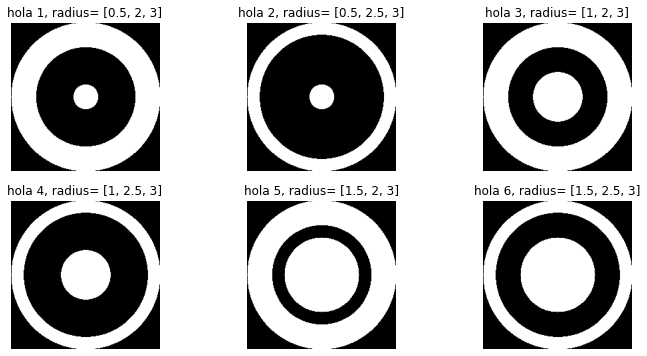

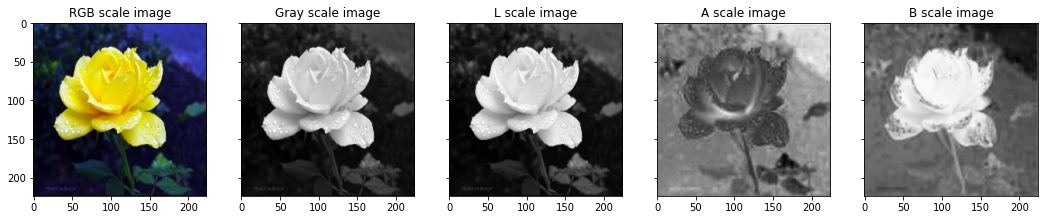

(<matplotlib.image.AxesImage at 0x14756819888>,
 Text(0.5, 1.0, 'enhanced saliency map c_prime'))

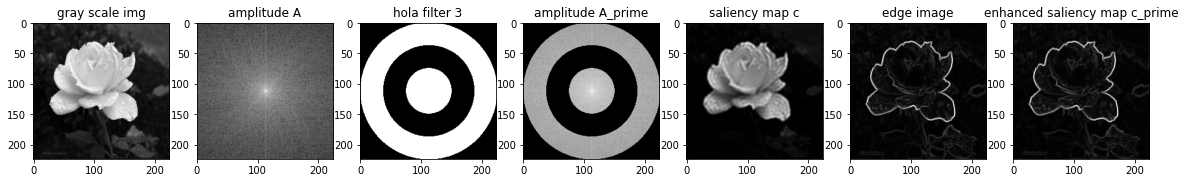

In [51]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from scipy import signal
from scipy.ndimage import gaussian_filter
from scipy import misc
from skimage import filters
from skimage.measure import shannon_entropy
import warnings
warnings.filterwarnings("ignore")

cen = 112
def mask(r):
    y, x = np.ogrid[0:224, 0:224]
    mask = (x-cen)**2+(y-cen)**2 <= r**2
    return mask
def kernel(mask):
    kernel = np.zeros((224, 224))
    kernel[mask] = 1
    return kernel
def hola_filter_gen(r):
    rate = 112 / r[2]
    radius = np.dot(rate,(r[0], r[1], r[2]))
    hola_filter = kernel(mask(radius[2]))-kernel(mask(radius[1]))+kernel(mask(radius[0]))
    return hola_filter

r = [[0.5, 2, 3],[0.5, 2.5, 3],[1, 2, 3],[1, 2.5, 3],[1.5, 2, 3],[1.5, 2.5, 3]]
hola_set = []
for i in r:
    hola_set.append(hola_filter_gen(i))
    
plt.figure(figsize=(12, 6))
for i in range(len(hola_set)):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(hola_set[i],'gray')
    plt.title(f'hola {i+1}, radius= {r[i]}')
    plt.axis("off")

def normalize(x): 
    ## f(.)
    return (x-np.min(x))/(np.max(x)-np.min(x))
def hola_thm(img,hola):
    hola_filter = hola_filter_gen(r[hola])
    ## fft
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    amplitude = np.log(np.abs(fshift))
    phase = np.angle(fshift)
    ## ifft
    A_prime = np.multiply(amplitude,hola_filter)
    ishift = np.fft.ifftshift(np.exp(A_prime+1j*phase))
    iimg = np.fft.ifft2(ishift)
    c = np.array(np.abs(iimg))**2
    c = normalize(c)
    ## Prewitt algorithm
    k = filters.prewitt(img) #input scale 0~255 or 0~1.0, output scale 0~1.0
    ## combine c & k
    c_prime = cv2.add(c, k)
    return c_prime
def entropy_2D(img):
    scale = 0.02; h, w = img.shape; size = np.int(scale*w) #做高斯模糊化
    img = cv2.GaussianBlur(img, (size,size), scale)
    img = normalize(img.astype(float))*255
    img = img.astype(np.uint8)
    score = shannon_entropy(img)
    return score

'''
Gray scale
'''
img_g = cv2.cvtColor(cv2.resize(y.astype('float32'), (224, 224)), cv2.COLOR_RGB2GRAY) #paper上除了 gray, 還有 LAB 3 channels
'''
LAB scale
'''
img_lab = cv2.cvtColor(cv2.resize(y.astype('uint8'), (224, 224)), cv2.COLOR_RGB2Lab)
img_l = img_lab[:,:,0]
img_a = img_lab[:,:,1]
img_b = img_lab[:,:,2]
f, (ax0 ,ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=5, sharey=True, figsize=(18, 6))
ax0.imshow(y), ax0.set_title('RGB scale image')
ax1.imshow(img_g,'gray'), ax1.set_title('Gray scale image')
ax2.imshow(img_l,'gray'), ax2.set_title('L scale image')
ax3.imshow(img_a,'gray'), ax3.set_title('A scale image')
ax4.imshow(img_b,'gray'), ax4.set_title('B scale image')
plt.show()

img = img_g
hola_f = hola_set[2]
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
amplitude = np.absolute(fshift)
phase = np.angle(fshift) #等價於 np.arctan
amplitude_p = np.multiply(amplitude,hola_f)

ishift = np.fft.ifftshift(amplitude_p*np.exp(1j*phase))
iimg = np.fft.ifft2(ishift)
iimg = np.absolute(iimg)**2
iimg = normalize(iimg)

f, (ax0, ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=7, figsize=(20,10))
ax0.imshow(img_g,'gray'), ax0.set_title('gray scale img')
ax1.imshow(np.log(amplitude),'gray'), ax1.set_title('amplitude A')
ax2.imshow(hola_f,'gray'), ax2.set_title(f'hola filter {2+1}')
ax3.imshow(np.log(amplitude_p+0.0001),'gray'), ax3.set_title('amplitude A_prime')
ax4.imshow(iimg,'gray'), ax4.set_title('saliency map c')
ax5.imshow(filters.prewitt(img_g),'gray'), ax5.set_title('edge image')
ax6.imshow(cv2.add(iimg,filters.prewitt(img_g)),'gray'), ax6.set_title('enhanced saliency map c_prime')

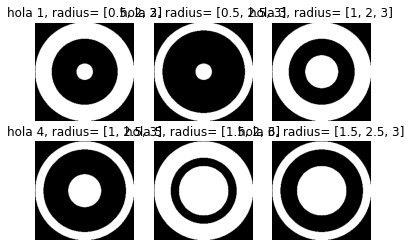

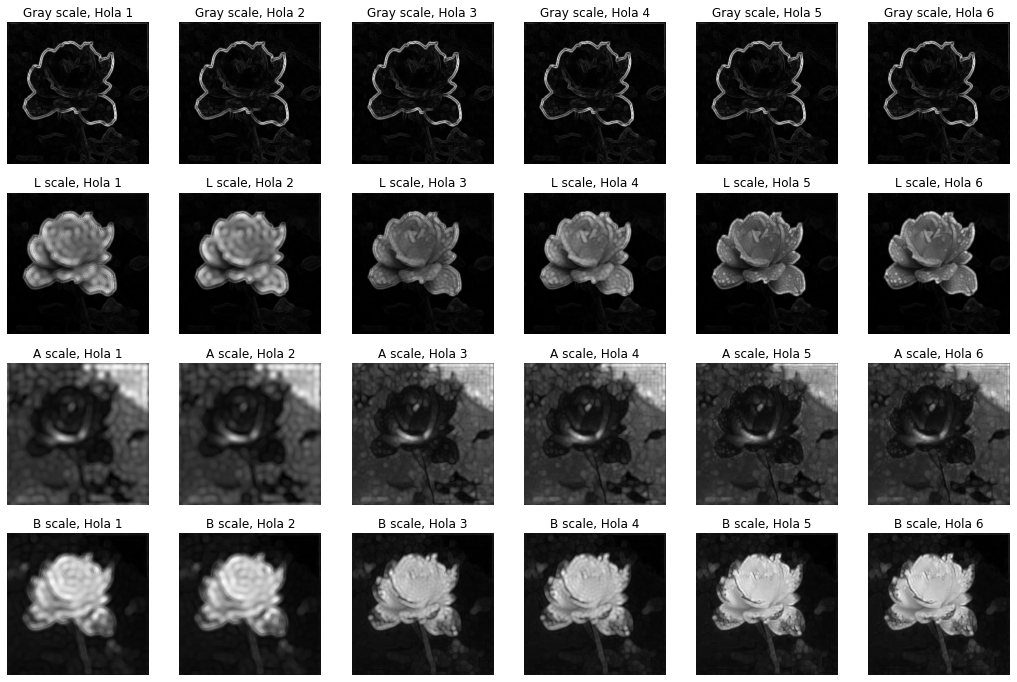

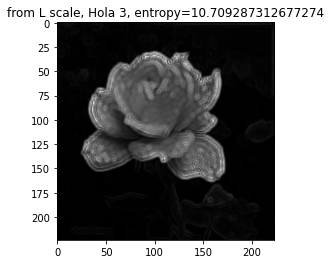

In [60]:
def matlab_style_gauss2D(shape,sigma):
    """ref:
    https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def entropy_2D(img):
    scale = 0.02; h, w = img.shape; sgm = scale*w
    p = normalize(img)
    z = p / np.sum(p)
    ker = matlab_style_gauss2D(shape=(w, w), sigma=w/4)
    ker = ker / np.max(ker)
    z = z*ker
    z = np.sum(z)
    p = signal.convolve2d(p, matlab_style_gauss2D(shape=(7, 7), sigma=sgm), boundary='symm', mode='same')
    p = normalize(p)*255
    p = img.astype(np.uint8)
    score = shannon_entropy(p) / z
    return score
    
from utils.utils import calcEntropy2dSpeedUp
def final_chose(image):
    saliencymap = []; entropy = []
    img_lab = cv2.cvtColor(cv2.resize(image.astype('uint8'), (224, 224)), cv2.COLOR_RGB2LAB)
    img_g = cv2.cvtColor(cv2.resize(image.astype('float32'), (224, 224)), cv2.COLOR_RGB2GRAY)
    img_l = img_lab[:,:,0]
    img_a = img_lab[:,:,1]
    img_b = img_lab[:,:,2]
    img_set = [img_g, img_l, img_a, img_b]
    for i in range(len(hola_set)):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(hola_set[i],'gray')
        plt.title(f'hola {i+1}, radius= {r[i]}')
        plt.axis("off")

    for i in range(len(img_set)):
        for j in range(len(hola_set)):
            c1 = hola_thm(img_set[i], hola=j)
            c2 = hola_thm(c1, hola=j)
            saliencymap.append(c2)
            entropy.append(calcEntropy2dSpeedUp((c2*255).astype('uint8')))
    final = np.argmin(entropy)
    plt.figure(figsize=(18, 12))
    for i in range(len(saliencymap)):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(saliencymap[i],'gray')
        if i//6 == 0:
            plt.title(f'Gray scale, Hola {i % 6 +1}')
        elif i //6 ==1:
            plt.title(f'L scale, Hola {i % 6 +1}')
        elif i //6 ==2:
            plt.title(f'A scale, Hola {i % 6 +1}')
        elif i //6 ==3:
            plt.title(f'B scale, Hola {i % 6 +1}')
        plt.axis("off")
    plt.show()
    plt.imshow(saliencymap[final], 'gray')
    if final//6 == 0:
        plt.title(f'from Gray scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==1:
        plt.title(f'from L scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==2:
        plt.title(f'fromA scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    elif final//6 ==3:
        plt.title(f'from B scale, Hola {final % 6 +1}, entropy={entropy[final]}')
    plt.show()
    return saliencymap[final], saliencymap
    
saliencymap_f, saliencymap = final_chose(y)

In [ ]:
from tqdm import tqdm
te_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Image')
te_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Mask')
batch_size = 1
dataset = DatasetGenerate(te_img_folder, te_gt_folder)
loader_args = dict(batch_size=batch_size, num_workers=4, prefetch_factor =2 , pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, **loader_args)
dataloaders = {
    'test': test_loader
}
root_path = r'C:\Users\User\pythonProject\mission87\eval_outputs'
pred_path = r'Hola'
p = pred_path
if not os.path.exists(os.path.join(root_path, p)):
    os.makedirs(os.path.join(root_path, p))

In [ ]:
i = 0
with torch.no_grad():
    for batch in tqdm(dataloaders['test']):
        image = batch['image'].squeeze(dim=0).permute(1, 2, 0).numpy()
        saliency_map = final_chose(image)
        obj = (saliency_map > np.mean(saliency_map)*3)
        result = Image.fromarray(obj)
        pred__path = os.path.join(root_path, pred_path, str(i) + '.png')
        Image_copy = Image.Image.copy(result)
        Image.Image.save(Image_copy, pred__path)
        i += 1

# Hypercomplex Fourier Transform (HFT)

In [ ]:
import quaternion
def rgb_to_quat(img):
    real_layer = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) # (300, 400, 1)
    
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    I = np.mean(img, axis=2)
    RG = (r-(g+b)/2) - (g-(r+b)/2) # f3
    Y = ((r+g)/2-np.abs(r-g)/2-b)
    BY = (b-(r+g)/2) - np.where(Y < 0, 0, Y)
    # new_img = np.concatenate((real_layer, img), axis=2)
    new_img = np.concatenate((real_layer, I[:, :, np.newaxis]*0.5, RG[:, :, np.newaxis]*0.25, BY[:, :, np.newaxis]*0.25), axis=2)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 25))
    ax1.imshow(img)
    ax1.set_title('orig')
    ax2.imshow(I)
    ax2.set_title('I')
    ax3.imshow(RG)
    ax3.set_title('RG')
    ax4.imshow(BY)
    ax4.set_title('BY')
    plt.show()
    plt.imshow(np.concatenate((RG[:, :, np.newaxis]*0.25, BY[:, :, np.newaxis]*0.25, I[:, :, np.newaxis]*0.5), axis=2), 'gray')
    plt.title('multiple feature maps')
    plt.show()
    return quaternion.as_quat_array(new_img)

def fqft(signal):
    signal = quaternion.as_float_array(signal)
    red = signal[:, :, 1]
    green = signal[:, :, 2]
    blue = signal[:, :, 3]
    red_ft = np.fft.fft(red)
    green_ft = np.fft.fft(green)
    blue_ft = np.fft.fft(blue)

    mu = np.quaternion(0, 1, 0, 0)
    i = np.quaternion(0, 1, 0, 0)
    j = np.quaternion(0, 0, 1, 0)
    k = np.quaternion(0, 0, 0, 1)

    ft = i*(np.real(red_ft) + mu*np.imag(red_ft)) + \
         j*(np.real(green_ft) + mu*np.imag(green_ft)) + \
         k*(np.real(blue_ft) + mu*np.imag(blue_ft))
    
    return ft

def MSQF(fl):
    fl = fl/ 224
    A = np.abs(fl)
    fl = np.divide(fl, A)
    A = np.log(1+np.fft.fftshift(A))
    Ak = cv2.GaussianBlur(A, (9, 9), 0)
    Ak = np.exp(np.fft.fftshift(Ak))-1
    fl_filted = np.multiply(Ak, fl)
    return fl_filted

def fiqft(signal):
    signal = quaternion.as_float_array(signal)
    quat_real = signal[:, :, 0]
    quat_i = signal[:, :, 1]
    quat_j = signal[:, :, 2]
    quat_k = signal[:, :, 3]
    real_ift = np.fft.ifft(quat_real)
    i_ift = np.fft.ifft(quat_i)
    j_ift = np.fft.ifft(quat_j)
    k_ift = np.fft.ifft(quat_k)

    mu = np.quaternion(0, 1, 0, 0)
    i = np.quaternion(0, 1, 0, 0)
    j = np.quaternion(0, 0, 1, 0)
    k = np.quaternion(0, 0, 0, 1)

    ft = np.real(real_ift) + mu*np.imag(real_ift) + \
         i*(np.real(i_ift) + mu*np.imag(i_ift)) + \
         j*(np.real(j_ift) + mu*np.imag(j_ift)) + \
         k*(np.real(k_ift) + mu*np.imag(k_ift))

    return ft

def quat_to_rgb(img):
    img = quaternion.as_float_array(img)
    return np.concatenate((img[:, :, 1, np.newaxis], img[:, :, 2, np.newaxis], img[:, :, 3, np.newaxis]), axis=2)

def normalize(x): 
    ## f(.)
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [ ]:
# s = rgb_to_quat(cv2.resize(new_y, (224, 224)))
s = rgb_to_quat(y)
f = fqft(s)
f_l = MSQF(f)
fi = fiqft(f_l)
i = normalize(quat_to_rgb(fi))
# i = cv2.cvtColor(i.astype('float32'), cv2.COLOR_BGR2GRAY)
plt.imshow(i, 'gray')

In [ ]:
s

In [ ]:
plt.imshow(i[:,:,0], 'gray')

In [ ]:
from tqdm import tqdm
te_img_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Image')
te_gt_folder = os.path.join(r'C:\Users\user\pythonProject\mission87\data\DUTS\DUTS-TE\DUTS-TE-Mask')
batch_size = 1
dataset = DatasetGenerate(te_img_folder, te_gt_folder)
loader_args = dict(batch_size=batch_size, num_workers=4, prefetch_factor =2 , pin_memory=True)
test_loader = DataLoader(dataset, shuffle=False, **loader_args)
dataloaders = {
    'test': test_loader
}
root_path = r'C:\Users\User\pythonProject\mission87\eval_outputs'
pred_path = r'HFT'
p = pred_path
if not os.path.exists(os.path.join(root_path, p)):
    os.makedirs(os.path.join(root_path, p))

In [ ]:
n = 0
with torch.no_grad():
    for batch in tqdm(dataloaders['test']):
        image = batch['image'].squeeze(dim=0).permute(1, 2, 0).numpy()

        s = rgb_to_quat(image)
        f = fqft(s)
        f_l = MSQF(f)
        fi = fiqft(f_l)
        i = normalize(quat_to_rgb(fi))
        saliency_map = cv2.cvtColor(i.astype('float32'), cv2.COLOR_BGR2GRAY)
        saliency_map = np.array(saliency_map)
        obj = (saliency_map > np.mean(saliency_map))
        result = Image.fromarray(obj)
        pred__path = os.path.join(root_path, pred_path, str(n) + '.png')
        Image_copy = Image.Image.copy(result)
        Image.Image.save(Image_copy, pred__path)
        n += 1

In [ ]:
saliency_map.shape

In [ ]:
import quaternion
def rgb_to_quat(img):
    real_layer = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) # (300, 400, 1)
    new_img = np.concatenate((real_layer, img), axis=2)
    return quaternion.as_quat_array(new_img)

# s = rgb_to_quat(np.ones((3,3,3))*0.5)
s = rgb_to_quat(new_y)
f = fqft(s)
fi = fiqft(f)
i = quat_to_rgb(fi)
i, np.ones((3,3,3))*0.5
plt.imshow(i)